# 데이콘 이상탐지 데이터 분석
---

In [1]:
!pip install --upgrade matplotlib

In [2]:
def detect_pressure_anomalies(df, pressure_col, n_neighbors=30, contamination=0.1, window_size=5):
    # 압력계 데이터만 사용
    pressure_data = df[[pressure_col]].copy()
    
    # 하락 패턴 특성 생성 및 NaN 처리
    pressure_data['diff'] = pressure_data[pressure_col].diff().fillna(method='bfill')
    
    # 이동평균과 표준편차 계산 (NaN 처리 포함)
    pressure_data['rolling_mean'] = (pressure_data[pressure_col]
                                   .rolling(window=window_size, min_periods=1)
                                   .mean()
                                   .fillna(method='bfill'))
    
    pressure_data['rolling_std'] = (pressure_data[pressure_col]
                                  .rolling(window=window_size, min_periods=1)
                                  .std()
                                  .fillna(method='bfill'))
    
    # 하락 구간만 필터링 (diff < 0)
    drop_mask = pressure_data['diff'] < 0
    drop_data = pressure_data[drop_mask].copy()
    
    if len(drop_data) == 0:
        return np.zeros(len(df))
    
    # NaN이 없는지 최종 확인
    X = drop_data[[pressure_col, 'diff', 'rolling_mean', 'rolling_std']].values
    if np.isnan(X).any():
        X = np.nan_to_num(X, nan=0)  # 남은 NaN을 0으로 대체
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lof = LocalOutlierFactor(
        n_neighbors=min(n_neighbors, len(X_scaled)-1),
        contamination=contamination,
        novelty=False,
        metric='euclidean'
    )
    
    predictions = np.zeros(len(df))
    drop_indices = pressure_data[drop_mask].index
    predictions[drop_indices] = lof.fit_predict(X_scaled)
    
    return np.where(predictions == -1, 1, 0)

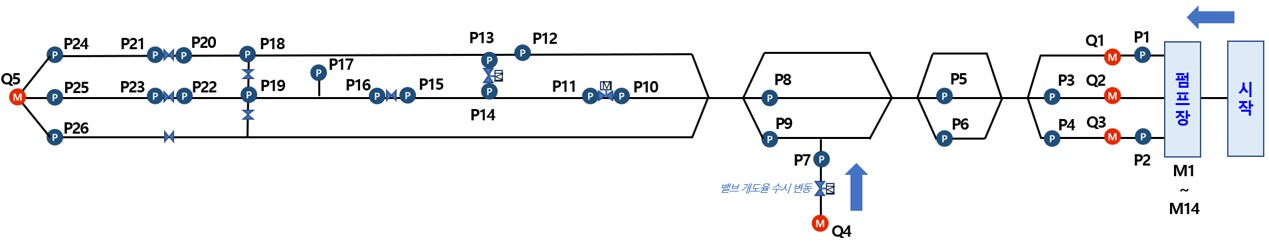

In [3]:
#밸브 개도율 압력계: p7, p10,p11,p13,p14,p15,p16,p18,p19,p20,p21,p22,p23

# M7펌프가 24/06/26 05:58 1에서 0으로 변함
# 압력계가 비정상이되면 14:20-부터 급격히 떨어지다가 정상화된 14:50부터 다시 올라감
- P가 anomaly 관측에 주요 변수로 보임(P8)
- 밸브 개도율 수시 변동과 p8 p9 사이 상관관계 가능
- Q4는 굉장히 중요한 변수다
- Q5가 완전 음에서 완전 양으로 바뀐다
- p7하고 q4가 상관관계 -1에 가까워 q4와 p7사이에 밸브는 개도율이 수시로 변동한다 
- p7이 압력이 높아졌을 때 밸브를 닫아서 q4의 유량이 감소했을 가능성이 있음
- 베르누이 원리에 의해서 정상상태에서는 유량과 압력이 음의 상관관계다
- 근데 anomaly상황에서 q5에서 양의 상관관계다
Anomaly 상황에서 유량과 압력이 양의 상관관계를 보이는 것은 시스템에 비정상적인 상태가 발생했음을 시사합니다. 이는 다음과 같은 상황을 나타낼 수 있습니다:
누수 발생: 파이프라인에 누수가 발생하면, 압력이 증가함에 따라 누수 지점을 통한 유량도 증가할 수 있습니다2. 이는 정상적인 흐름과는 다른 패턴을 보이게 됩니다.
막힘 현상: 파이프라인에 부분적인 막힘이 발생하면, 압력이 증가하면서 동시에 유량도 증가할 수 있습니다. 이는 막힘을 통과하기 위해 더 높은 압력이 필요하기 때문입니다2.
펌프 오작동: 시스템 내 펌프가 비정상적으로 작동하면, 압력과 유량이 동시에 증가하는 현상이 나타날 수 있습니다3.
밸브 오작동: 제어 밸브가 제대로 작동하지 않으면, 압력과 유량 사이의 정상적인 관계가 무너질 수 있습니다.
결론
이러한 관찰 결과는 시스템의 정상 상태와 비정상 상태를 구분하는 중요한 지표가 될 수 있습니다4. 유량과 압력 사이의 관계가 갑자기 변화하는 것은 시스템에 문제가 발생했음을 나타내는 신호일 수 있으며, 이를 통해 조기에 문제를 감지하고 대응할 수 있습니다. 따라서 이러한 패턴 변화를 모니터링하는 것은 수도 공급 시스템의 효율적인 관리와 유지보수에 매우 중요합니다5.

# 데이터 정보

In [4]:
df_A = pd.read_csv("TRAIN_A.csv")

print(df_A.columns)
print("칼럼 수 : ",len(df_A.columns))
print("차원 : ",df_A.shape)


# 새로운 열 생성: Q5 - (Q1 + Q2 + Q3 + Q4)
df_A['leakage'] = df_A['Q1'] + df_A['Q2'] + df_A['Q3'] + df_A['Q4'] - df_A['Q5']
#df_A['leakage_diff'] = df_A['leakage'].diff()

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P26', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag', 'P11_flag', 'P12_flag', 'P13_flag', 'P14_flag', 'P15_flag',
       'P16_flag', 'P17_flag', 'P18_flag', 'P19_flag', 'P20_flag', 'P21_flag',
       'P22_flag', 'P23_flag', 'P24_flag', 'P25_flag', 'P26_flag'],
      dtype='object')
칼럼 수 :  73
차원 :  (44101, 73)


In [5]:
# 2. Isolation Forest 모델 정의
iso_forest = IsolationForest(
    contamination=0.01,  # anomaly 비율
    random_state=42,
    n_estimators=100
)

In [6]:
# 3. 학습 데이터 준비 (leakage만 사용)
X = df_A['leakage'].values.reshape(-1, 1)
iso_forest.fit(X)

IsolationForest(contamination=0.01, random_state=42)

In [7]:
# 4. Anomaly 예측
anomaly_pred = iso_forest.predict(X)
df_A['predicted_anomaly'] = np.where(anomaly_pred == -1, 1, 0)

In [8]:
# 5. 시각화
plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

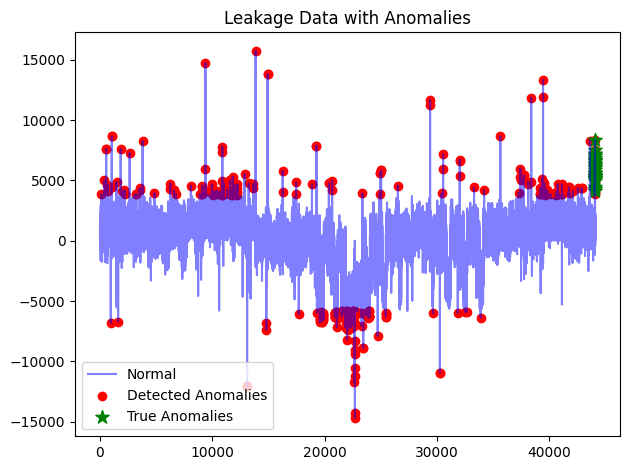

In [9]:
# Leakage 데이터와 예측된/실제 anomaly 플롯
plt.plot(df_A.index, df_A['leakage'], 'b-', label='Normal', alpha=0.5)
plt.scatter(df_A.index[df_A['predicted_anomaly'] == 1],
           df_A['leakage'][df_A['predicted_anomaly'] == 1],
           color='red', label='Detected Anomalies')
plt.scatter(df_A.index[df_A['anomaly'] == 1],
           df_A['leakage'][df_A['anomaly'] == 1],
           color='green', marker='*', s=100, label='True Anomalies')
plt.title('Leakage Data with Anomalies')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# 6. 성능 평가
true_anomalies = df_A[df_A['anomaly'] == 1]
detected_anomalies = df_A[df_A['predicted_anomaly'] == 1]
matching = df_A[(df_A['anomaly'] == 1) & (df_A['predicted_anomaly'] == 1)]

print(f"실제 anomaly 수: {len(true_anomalies)}")
print(f"탐지된 anomaly 수: {len(detected_anomalies)}")
print(f"일치하는 anomaly 수: {len(matching)}")
print(f"탐지 정확도: {len(matching)/len(true_anomalies)*100:.2f}%")

실제 anomaly 수: 30
탐지된 anomaly 수: 440
일치하는 anomaly 수: 30
탐지 정확도: 100.00%


In [1]:
print(f"실제 anomaly 수: {len(true_anomalies)}")
print(f"탐지된 anomaly 수: {len(detected_anomalies)}")
print(f"일치하는 anomaly 수: {len(matching)}")
print(f"탐지 정확도: {len(matching)/len(true_anomalies)*100:.2f}%")


NameError: name 'true_anomalies' is not defined

In [ ]:
# 7. 주요 anomaly 시점 출력
print("\n주요 anomaly 발생 시점:")
print(true_anomalies[['timestamp', 'leakage']].head())

In [2]:
def plot_leakage_anomalies(diff_threshold, std_threshold):
    # 1. Leakage 변화율과 표준편차 계산
    df_A['leakage_diff'] = df_A['leakage'].diff()
    df_A['leakage_std'] = df_A['leakage'].rolling(window=5).std()
    
    # 2. Threshold 기반 anomaly 탐지
    anomaly_mask = (abs(df_A['leakage_diff']) > diff_threshold) | \
                  (df_A['leakage_std'] > std_threshold)
    
    # 3. 시각화
    plt.figure(figsize=(15, 10))
    
    # Leakage 데이터와 anomaly 플롯
    plt.subplot(3, 1, 1)
    plt.plot(df_A.index, df_A['leakage'], 'b-', label='Normal', alpha=0.5)
    plt.scatter(df_A.index[anomaly_mask],
               df_A['leakage'][anomaly_mask],
               color='red', label='Anomalies')
    plt.title('Leakage Data with Anomalies')
    plt.legend()
    
    # 변화율 플롯
    plt.subplot(3, 1, 2)
    plt.plot(df_A.index, df_A['leakage_diff'], 'g-', label='Diff', alpha=0.5)
    plt.axhline(y=diff_threshold, color='r', linestyle='--', label='Upper Threshold')
    plt.axhline(y=-diff_threshold, color='r', linestyle='--', label='Lower Threshold')
    plt.title('Leakage Change Rate')
    plt.legend()
    
    # 이동 표준편차 플롯
    plt.subplot(3, 1, 3)
    plt.plot(df_A.index, df_A['leakage_std'], 'purple', label='Std', alpha=0.5)
    plt.axhline(y=std_threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Rolling Standard Deviation')
    plt.legend()
    
    plt.tight_layout()
    
    # 통계 출력
    print(f"Number of anomalies detected: {anomaly_mask.sum()}")
    print(f"Percentage of anomalies: {(anomaly_mask.sum()/len(df_A))*100:.2f}%")

# 인터랙티브 위젯 생성
interact(
    plot_leakage_anomalies,
    diff_threshold=widgets.FloatSlider(
        value=1000,
        min=100,
        max=5000,
        step=100,
        description='Diff Threshold:'
    ),
    std_threshold=widgets.FloatSlider(
        value=500,
        min=100,
        max=2000,
        step=100,
        description='Std Threshold:'
    )
)

NameError: name 'interact' is not defined

In [ ]:
# 결과 확인 (처음 5행 출력)
print(df_A[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'leakage']].head())

`-` 해결해야할 문제 : P 압력계에서 일어나는 이상치를 탐지

- Q1 ~ Q5 : 유량 정량 정보
- M1 ~ M14 : 이진 분류되어진 펌프가동정보, 이산형 데이터 0이면 꺼진거 1이면 켜진거
- P1 ~ P26 : 해당 펌프의 상수도의 압력계 정량 정보 0이면 정상 1이면 이상치!!
- P1_flag ~ P26_flag : 어떠한 P에 이상 탐지 여부, 이진 분류, test set에선 제공되지 않는다
- anomaly : 이상 탐지 여부, train set에서만 존재, P1_flag ~ P26_flag에서 감지되면 해당 변수에서도 체크된다, test set에선 제공되지 않는다
- Data set : $ D_{train} \in R^{n \times m} $ , $n = 1,2,...,44101,\quad m = 1,2,...,73$
- $n$단위는 1분, 결측치 존재 X


---
# EDA 
- 이상탐지여부 중심으로 진행
- 매우 낮은 이상치 갯수 

In [ ]:
plt.pie(df_A[["anomaly"]].value_counts(),autopct='%1.1f%%')
plt.title("pie graph for outlier ratio")
plt.show()

In [ ]:
df_true = df_A[df_A["anomaly"] == 1].iloc[:,1:(5+14+26+1)]
df_false = df_A[df_A["anomaly"] != 1].iloc[:,1:(5+14+26+1)]

## Q1~Q5 박스플랏
- 시계열 데이터를 박스플랏으로 보기는 조금 난해하지만 이상치가 표본으로부터 얼마나 거리가 떨어져있는지 확인하기 위해 박스플랏을 그려보았다
- Q3는 다른 데이터에 비해 분포가 매우 큰 차이가 날 것으로 보인다.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

titles = ["Q1", "Q2", "Q3", "Q4", "Q5"]
data = [df_true.iloc[:, i].values for i in range(5)]
labels = ["True", "False"]

for i in range(5):
    row, col = divmod(i, 3)  # 2x3 배열에서 행(row)과 열(col) 계산
    ax[row, col].boxplot(
        [data[i], df_false.iloc[:, i].values], 
        labels=labels
    )
    ax[row, col].set_title(titles[i])

# 필요 없는 격자 숨기기 (마지막 서브플롯)
ax[1, 2].axis("off")


plt.tight_layout()  # 레이아웃 조정
plt.show()

## Q1~Q5 시도표
- 그래프를 통해, 시계열 추세가 매우 변동이 큰 것을 보아 포인트를 찾는 이상치 기법보단 구간별로 이상치를 찾아야할 것으로 보인다.

In [ ]:
fig, ax = plt.subplots(5,1,figsize=(10,10))
for i in range(0,5):
    ax[i].plot(df_A[f'Q{i+1}'])
    ax[i].set_title(titles[i])

plt.tight_layout()
plt.show()

## 이상치 구간 시각화

In [ ]:
# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 정상 데이터 플롯
ax.plot(
    df_A.index[-40000:],  # 시간 축
    df_A['leakage'][-40000:],  # leakage 데이터
    label="Normal Data",
    color="blue",
    linewidth=1,
    alpha=0.7
)

# 이상치 데이터 플롯
ax.plot(
    df_A.index[df_A["anomaly"] == 1],  # 이상치의 시간
    df_A['leakage'][df_A["anomaly"] == 1],  # 이상치의 leakage 값
    label="Anomalies",
    color="red",
    marker='o',
    linestyle='None',
    markersize=5
)

# 그래프 설정
ax.set_title('Leakage Data with Anomalies')
ax.set_xlabel('Time')
ax.set_ylabel('Leakage')
ax.legend()

plt.show()

In [ ]:
# Select pump operation data (M1 to M14) and leakage
data_pump = df_A[['leakage', 'anomaly'] + [f'M{i}' for i in range(1, 15)]]

# Create a custom palette
palette = {0: 'blue', 1: 'red'}

# Create a pairplot to visualize relationships between leakage and pump operation
g = sns.pairplot(data_pump, y_vars=['leakage'], x_vars=[f'M{i}' for i in range(1, 15)],
                 kind='scatter', height=5, aspect=1.2,
                 plot_kws={'alpha': 0.6, 'edgecolor': 'none'},
                 hue='anomaly', palette=palette)

# Adjust the layout and title
g.fig.suptitle('Relationship between Leakage and Pump Operation (M1 to M14)', y=1.02, fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

1. M1-0 
2. M2-0
3. M3-0
4. M4-대부분1 anomaly
5. M5-0,1반반 0일때 anomaly
6. M6-0,1 반반 0일 때 anomaly
7. M7- 0,1 반반 0일 때 anomaly
8. M8- 0,1 중 1이 조금더 많음, 1일때 anomaly
9. M9-0,1 중 1이 조금 더 많음, 1일 때 anomaly
10. M10- 0
11. M11-0,1 중 1이 조금 더 많음, 1일 때 anomaly
12. M12-0,1 중 0이 조금 더 많음, 1일 때 anomaly
13. M13-0
14. M14 반반 1일때 anomaly 

In [ ]:
# Select pressure sensor data (P1 to P26), leakage, and anomaly
data_pressure = df_A[['leakage', 'anomaly'] + [f'P{i}' for i in range(1, 27)]]

# Create a pairplot for pressure sensors vs leakage with anomaly highlighting
palette = {0: 'blue', 1: 'red'}  # Normal data in blue, anomalies in red
g = sns.pairplot(
    data_pressure,
    y_vars=['leakage'],
    x_vars=[f'P{i}' for i in range(1, 27)],
    hue='anomaly',
    palette=palette,
    kind='scatter',
    height=5,
    aspect=1.2,
    plot_kws={'alpha': 0.6}
)

# Adjust the layout and title
g.fig.suptitle('Relationship between Leakage and Pressure Sensors (P1 to P26)', y=1.02, fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()
#p_flag에 대한 인사이트 보인다. p7,8,9에서 확실히

In [ ]:
# 펌프 가동 여부(M1~M14)와 누수 데이터 상관관계 히트맵
plt.figure(figsize=(12, 8))
pump_corr = df_A[['leakage'] + [f'M{i}' for i in range(1, 15)]].corr()
sns.heatmap(pump_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation between Leakage and Pump Operation (M1-M14)')
plt.show()

In [ ]:
# 압력 센서 데이터(P1~P26)와 누수 데이터 상관관계 히트맵
plt.figure(figsize=(16, 10))
pressure_corr = df_A[['leakage'] + [f'P{i}' for i in range(1, 27)]].corr()
sns.heatmap(pressure_corr, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation between Leakage and Pressure Sensors (P1-P26)')
plt.show()

## M1~M14
- 아래 표는 이상치 여부가 1인 데이터의 M1~M14를 합산하여 평균낸 것으로 이상치가 탐지된 구간에서 비율이 1인 것을 알 수 있다.
  - 이는 TRAIN_A 데이터에서 이상치는 M4, M8, M9, M11, M12, M14이 무조건 1로 체크되어있다는 의미이다.
- 하지만 이상치여부가 0인 데이터는 이상치와는 다르게 집계된 것을 확인할 수 있다.

In [ ]:
pd.DataFrame({'anomaly':np.sum(df_true.iloc[:,5:(5+14)],axis=0) / 30,
              'No anomaly':np.sum(df_false.iloc[:,5:(5+14)],axis=0) / len(df_false)})#,np.sum(df_false.iloc[:,5:(5+14)],axis=0)

## P1 ~ P26 시도표
- 관망구조를 보면 P1부터 P26은 하나의 구조로 이루어져 있는 것을 확인하였다.
- 이는 서로 집계되는 압력이 어느정도 상관관계가 있을 것으로 보이며, 다변량 문제로 접근해봐야 한다는 의미로도 볼 수 있다.
- 시도표에서도 추세, 계절 성분으로 보이는 것들이 근접한 P 사이에서 대체적으로 비슷하게 나타나 있는 것을 확인할 수 있었다. 

In [ ]:
P = df_true.columns[[df_true.columns[i][0] == 'P' for i in range(len(df_true.columns))]]

fig, ax = plt.subplots(len(P),1,figsize=(10,50))
df_Ap= df_A[P]
for i in range(len(P)):
    ax[i].plot(df_Ap[f'P{i+1}'])
    ax[i].set_title(P[i])

plt.tight_layout()
plt.show()
#밸브 개도율 압력계: p7,p10,p11,p13,p14,p15,p16,p18,p19,p20,p21,p22,p23
#p17은 독립적

## 이상치 시각화

- P 데이터는 이상치 여부를 판단하는 아주 중요한 변수로 보인다.
- TEST SET에서도 P의 개수에 따라 제출해야하는 이상치 개수가 달라진다. 예를 들어 TEST-C0000이 P가 10개면, 10개에 대한 이상치 탐지 여부를 제출해야한다는 의미이다.

In [ ]:
# P로 시작하는 컬럼 선택
P = df_true.columns[[df_true.columns[i][0] == 'P' for i in range(len(df_true.columns))]]
df_Ap = df_A[P]  # P로 시작하는 열만 선택

# 플롯 생성
fig, ax = plt.subplots(len(P), 1, figsize=(10, 50))

for i in range(len(P)):
    # 정상 데이터 플롯
    ax[i].plot(
        df_A.index[35000:45000],  # 시간 축
        df_Ap[P[i]][35000:45000],  # P 데이터
        label="Normal Data",
        color="blue",
        linewidth=1,
        alpha=0.7
    )

    # 이상치 데이터 플롯
    ax[i].plot(
        df_A.index[df_A["anomaly"] == 1],  # 이상치 시간
        df_Ap[P[i]][df_A["anomaly"] == 1],  # 이상치 값
        label="Anomalies",
        color="red",
        linewidth=1.5  # 두께 강조
    )

    # 평균선 추가
    mean_value = df_Ap[P[i]].mean()  # 평균값 계산
    ax[i].axhline(mean_value, color="green", linestyle="--", label="Mean")  # 수평선 추가

    # 제목 및 범례 추가
    ax[i].set_title(P[i])
    ax[i].legend()

plt.tight_layout()  # 레이아웃 조정
plt.show()


In [ ]:
import pandas as pd

# anomaly == 1인 데이터에서 timestamp 열만 선택
timestamps = df_A[df_A["anomaly"] == 1]["timestamp"]

# DataFrame으로 변환 (엑셀 저장을 위해)
timestamps_df = timestamps.reset_index(drop=True).to_frame(name="timestamp")

# 엑셀 파일로 저장
timestamps_df.to_excel("timestamps.xlsx", index=False)

print("timestamp 데이터가 'timestamps.xlsx' 파일로 저장되었습니다.")

In [ ]:
timestamps_df

In [ ]:
df_A[df_A["anomaly"] == 1]

In [ ]:
#시계열 자료로 변환
df_A['timestamp'] = pd.to_datetime(df_A['timestamp'], format='%y/%m/%d %H:%M')

In [ ]:
df_A['timestamp'].head()

In [ ]:
# anomaly가 1인 시간대 찾기
anomaly_times = df_A[df_A['anomaly'] == 1]['timestamp']

In [ ]:
print(df_A['timestamp'].min(), df_A['timestamp'].max())

In [ ]:
# anomaly가 1인 연속된 구간 찾기
anomaly_start = df_A[df_A['anomaly'] == 1]['timestamp'].min()
anomaly_end = df_A[df_A['anomaly'] == 1]['timestamp'].max()

In [ ]:
anomaly_start

In [ ]:
anomaly_end

In [ ]:
# 데이터 추출
filtered_data = df_A[df_A["anomaly"] == 1]

In [ ]:
filtered_data

In [ ]:
filtered_data.head()

In [ ]:
# p1부터 p10까지의 데이터 시각화
plt.figure(figsize=(14, 8))
for i in range(1, 27):
    plt.plot(filtered_data['timestamp'], filtered_data[f'P{i}'], label=f'P{i}')

# anomaly 구간 강조
plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='Anomaly Period')

plt.title('Changes of P1 to P26 in filtered_data with Anomaly Period Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# p1부터 p10까지의 데이터 시각화
plt.figure(figsize=(14, 8))
for i in range(8, 10):
    plt.plot(filtered_data['timestamp'], filtered_data[f'P{i}'], label=f'P{i}')

# anomaly 구간 강조
plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='Anomaly Period')

plt.title('Changes of P8 to P9 in filtered_data with Anomaly Period Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# 숫자형 컬럼만 선택 (timestamp와 같은 비숫자형 컬럼 제외)
numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns

In [ ]:
# P8, P9를 포함한 모든 숫자형 컬럼 간의 상관관계 계산
correlation_matrix = filtered_data[numeric_columns].corr()

In [ ]:
# P8, P9와 다른 컬럼들 간의 상관관계만 선택
p8_p9_correlations = correlation_matrix.loc[['P8', 'P9'], :]

In [ ]:
# 히트맵 생성
plt.figure(figsize=(20, 6))
sns.heatmap(p8_p9_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation of P8 and P9 with Other Columns')
plt.tight_layout()
plt.show()

In [ ]:
# P8, P9와 가장 상관관계가 높은 상위 5개 컬럼 출력
print("P8과 가장 상관관계가 높은 상위 10개 컬럼:")
print(correlation_matrix['P8'].sort_values(ascending=False)[1:11])  # P8 자신 제외

In [ ]:
# P8, P9와 가장 상관관계가 높은 상위 5개 컬럼 출력
print("P9와 가장 상관관계가 높은 상위 10개 컬럼:")
print(correlation_matrix['P9'].sort_values(ascending=False)[1:11])

In [ ]:
# M으로 시작하는 컬럼 선택
m_columns = [col for col in filtered_data.columns if col.startswith('M')]

# P8, P9와 M으로 시작하는 컬럼 간의 상관관계 계산
correlation_matrix_p_m = filtered_data[['P8', 'P9'] + m_columns].corr()

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_p_m, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P8, P9 and M Columns')
plt.tight_layout()
plt.show()


- Anomaly를 관측할 때 펌프와 압력사이의 상관관계가 0일수록 누수가 났을 가능성이 높다(가설)
- TrainB도 이 가설처럼 나오면 모델을 돌릴때 펌프의 역할은 거의 없을 수도 있다

In [ ]:
# P1부터 P26까지의 컬럼 선택
p_columns = [f'P{i}' for i in range(1, 27)]

# P1부터 P26까지의 상관관계 계산
correlation_matrix_p = filtered_data[p_columns].corr()

# 히트맵 생성
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_p, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P1 to P26 Columns')
plt.tight_layout()
plt.show()
#p17은 고인물

In [ ]:
# P1부터 P26까지의 컬럼과 Q1부터 Q5까지의 컬럼 선택
p_columns = [f'P{i}' for i in range(1, 27)]
q_columns = [f'Q{i}' for i in range(1, 6)]

# P 컬럼들과 Q 컬럼들 간의 상관관계 계산
correlation_matrix_pq = filtered_data[p_columns + q_columns].corr().loc[p_columns, q_columns]

# 히트맵 생성
plt.figure(figsize=(12, 16))
sns.heatmap(correlation_matrix_pq, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P Columns and Q Columns')
plt.xlabel('Q Columns')
plt.ylabel('P Columns')
plt.tight_layout()
plt.show()

# 가장 높은 상관관계를 가진 P-Q 쌍 5개 출력
correlation_pairs = []
for p in p_columns:
    for q in q_columns:
        correlation_pairs.append((p, q, correlation_matrix_pq.loc[p, q]))

top_5_correlations = sorted(correlation_pairs, key=lambda x: abs(x[2]), reverse=True)[:5]

print("가장 높은 상관관계를 가진 P-Q 쌍 5개:")
for p, q, corr in top_5_correlations:
    print(f"{p} - {q}: {corr:.4f}")

In [ ]:
# 산점도 생성
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='P7', y='Q4')

# 회귀선 추가
sns.regplot(data=filtered_data, x='P7', y='Q4', scatter=False, color='red')

# 그래프 제목과 축 레이블 설정
plt.title('Relationship between P7 and Q4')
plt.xlabel('P7')
plt.ylabel('Q4')

# 상관계수 계산 및 표시
correlation = filtered_data['P7'].corr(filtered_data['Q4'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 추가적인 통계 정보 출력
print(f"P7와 Q4의 상관계수: {correlation:.4f}")
print("\n기술 통계:")
print(filtered_data[['P7', 'Q4']].describe())

## 전체 데이터의 경우

In [ ]:
# P1부터 P26까지의 컬럼과 Q1부터 Q5까지의 컬럼 선택
p_columns = [f'P{i}' for i in range(1, 27)]
q_columns = [f'Q{i}' for i in range(1, 6)]

# P 컬럼들과 Q 컬럼들 간의 상관관계 계산
correlation_matrix_pq = df_A[p_columns + q_columns].corr().loc[p_columns, q_columns]

# 히트맵 생성
plt.figure(figsize=(12, 16))
sns.heatmap(correlation_matrix_pq, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P Columns and Q Columns')
plt.xlabel('Q Columns')
plt.ylabel('P Columns')
plt.tight_layout()
plt.show()

# 가장 높은 상관관계를 가진 P-Q 쌍 5개 출력
correlation_pairs = []
for p in p_columns:
    for q in q_columns:
        correlation_pairs.append((p, q, correlation_matrix_pq.loc[p, q]))

top_5_correlations = sorted(correlation_pairs, key=lambda x: abs(x[2]), reverse=True)[:5]

print("가장 높은 상관관계를 가진 P-Q 쌍 5개:")
for p, q, corr in top_5_correlations:
    print(f"{p} - {q}: {corr:.4f}")